In [ ]:
# chapter 4-1 IPythonの実行時間計測

In [ ]:
n=100000

In [ ]:
%timeit sum([1. / i**2 for i in range(1, n)])

In [ ]:
%%timeit s = 0.
for i in range(1, n):
    s += 1. / i**2

In [ ]:
import numpy as np

In [ ]:
%timeit np.sum(1. / np.arange(1., n) ** 2)

In [ ]:
# chapter 4-2 cProfileとIPythonによるコードプロファイル

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
%matplotlib inline

In [ ]:
def step(*shape):
    # +1と-1の値をランダムに並べたn-vectorを作成
    return 2 * (np.random.random_sample(shape) < .5) -1

In [ ]:
%%prun -s cumulative -q -l 10 -T prun0
n = 10000
iterations = 50
x = np.cumsum(step(iterations, n), axis=0)
bins = np.arange(-30, 30, 1)
y = np.vstack([np.histogram(x[i,:], bins)[0] for i in range(iterations)])

In [ ]:
print(open('prun0', 'r').read())

In [ ]:
%%prun -s cumulative -q -l 10 -T prun0
n = 10000
iterations = 500
x = np.cumsum(step(iterations, n), axis=0)
bins = np.arange(-30, 30, 1)
y = np.vstack([np.histogram(x[i,:], bins)[0] for i in range(iterations)])

In [ ]:
print(open('prun0', 'r').read())

In [ ]:
# 4-3 line_profilerを使った行単位のコードプロファイル

In [ ]:
# line_profilerのインストール
# !pip install line_profiler

In [ ]:
import numpy as np

In [ ]:
%load_ext line_profiler

In [ ]:
%%writefile simulation.py
import numpy as np
def step(*shape):
    # +1と-1の値をランダムに並べたn-vectorを作成
    return 2 * (np.random.random_sample(shape) < .5) -1
def simulate(iterations, n = 10000):
    s = step(iterations, n)
    x = np.cumsum(s, axis=0)
    bins = np.arange(-30, 30, 1)
    y = np.vstack([np.histogram(x[i,:], bins)[0] for i in range(iterations)])
    return y

In [ ]:
import simulation

In [ ]:
%lprun -T lprof0 -f simulation.simulate simulation.simulate(50)

In [ ]:
print(open('lprof0', 'r').read())

In [ ]:
%lprun -T lprof0 -f simulation.simulate simulation.simulate(500)

In [ ]:
print(open('lprof0', 'r').read())

In [1]:
# chapter 4-4 memory_profilerを使ったメモリ使用状況のプロファイル

In [2]:
# memory_profilerのインストール
# !pip install memory_profiler

In [3]:
import simulation

In [4]:
%load_ext memory_profiler

In [5]:
%mprun -T mprof0 -f simulation.simulate simulation.simulate(50)



*** Profile printout saved to text file mprof0. 


In [6]:
%mprun -T mprof0 -f simulation.simulate simulation.simulate(500)



*** Profile printout saved to text file mprof0. 


In [7]:
# chapter 4-5 不必要な配列コピーを削除するためのNumPy内部構造解説

In [8]:
import numpy as np

In [9]:
a = np.zeros(10)

In [10]:
def id(x):
# 配列のメモリブロックのアドレスを返す
    return x.__array_interface__['data'][0]

In [11]:
id(a), id(a[1:])
# オフセットが異なればメモリ位置も異なる

(140655861334592, 140655861334600)

In [12]:
# 2つの配列が同じバッファを共有しているのかを確かめるためのより汎用で厳密な方法

def get_data_base(arr):
    # 指定されたNumPy配列のデータを格納している配列のアドレスを求める
    base = arr
    while isinstance(base.base, np.ndarray):
        base = base.base
        
    return base

def arrays_share_data(x, y):
    return get_data_base(x) is get_data_base(y)

In [13]:
print(arrays_share_data(a,a.copy()),
     arrays_share_data(a,a[1:]))

False True


In [14]:
a = np.zeros(10); aid = id(a); aid

140655861071360

In [15]:
b = a.copy(); id(b) == aid
# 違うアドレスになる

False

In [16]:
a *= 2; id(a) == aid
# 同じアドレス、元の配列の内容が変更される

True

In [17]:
a = a*2; id(a) == aid
# 違うアドレス、元の配列が暗黙のうちにコピーされ新しい配列が作成される

False

In [18]:
%%timeit a = np.zeros(10000000)
a *= 2
# 変更、速い

The slowest run took 4.59 times longer than the fastest. This could mean that an intermediate result is being cached.
100 loops, best of 3: 8.55 ms per loop


In [19]:
%%timeit a = np.zeros(10000000)
a = a*2
# コピー、遅い

10 loops, best of 3: 25.7 ms per loop


In [20]:
a = np.zeros((10, 10)); aid = id(a)

In [21]:
b = a.reshape((1, -1)); id(b) == aid
# 2次元配列の形状変更ではコピーが起こらないが、、

True

In [22]:
c = a.T.reshape((1, -1)); id(c) == aid
# 転置を伴う場合にはコピーが発生する

False

In [23]:
d = a.flatten(); id(d) == aid
# flattenは常に配列のコピーを返すが、、

False

In [24]:
e = a.ravel(); id(e) == aid
# ravelは必要な場合にだけコピーを行う

True

In [25]:
%timeit a.flatten()

The slowest run took 39.72 times longer than the fastest. This could mean that an intermediate result is being cached.
1000000 loops, best of 3: 916 ns per loop


In [26]:
%timeit a.ravel()

The slowest run took 18.90 times longer than the fastest. This could mean that an intermediate result is being cached.
1000000 loops, best of 3: 335 ns per loop


In [27]:
# ブロードキャストルール(2つの配列の形状が全く同じか、いずれかの次元長が1である場合に両者が互換であるとする)
# により配列の形状が異なっていても直接計算できる。
# reshapeやtileを使って形状を合わせる必要は必ずしもない。

In [28]:
n = 1000

In [29]:
a = np.arange(n)
ac = a[:, np.newaxis] # 列ベクトル
ar = a[np.newaxis, :] # 行ベクトル

In [30]:
% timeit np.tile(ac, (1, n)) * np.tile(ar, (n, 1))
# タイリングを使って計算、遅い

100 loops, best of 3: 12.7 ms per loop


In [31]:
%timeit ac * ar
# ブロードキャストにより直接計算、速い

100 loops, best of 3: 3.07 ms per loop


In [32]:
# 以下の2つの例のパフォーマンスの違いの理由は？
# 答えは書いてない。NumPyの内部構造が行優先だから？？？

In [33]:
a = np.random.rand(5000, 5000)

In [34]:
%timeit a[0,:].sum()
# 速い

The slowest run took 7.59 times longer than the fastest. This could mean that an intermediate result is being cached.
100000 loops, best of 3: 7.14 µs per loop


In [35]:
%timeit a[:,0].sum()
# 遅い

10000 loops, best of 3: 77.7 µs per loop


In [36]:
# chapter 4-6 NumPyのストライドトリック

In [38]:
x = np.zeros(10); x.strides

(8,)

In [40]:
y =np.zeros((10, 10)); y.strides

(80, 8)

In [41]:
n = 1000; a = np.arange(n)

In [47]:
b = np.lib.stride_tricks.as_strided(a, (n, n), (0, 8))

In [48]:
b

array([[  0,   1,   2, ..., 997, 998, 999],
       [  0,   1,   2, ..., 997, 998, 999],
       [  0,   1,   2, ..., 997, 998, 999],
       ..., 
       [  0,   1,   2, ..., 997, 998, 999],
       [  0,   1,   2, ..., 997, 998, 999],
       [  0,   1,   2, ..., 997, 998, 999]])

In [51]:
b.size, b.shape, b.nbytes

(1000000, (1000, 1000), 8000000)

In [54]:
b.dtype

dtype('int64')

In [55]:
%timeit b * b.T

100 loops, best of 3: 3.07 ms per loop


In [57]:
timeit np.tile(a, (n, 1)) * np.tile(a[:, np.newaxis], (1, n))

100 loops, best of 3: 12.8 ms per loop


In [58]:
# ストライドを使った移動平均の効率的計算アルゴリズム

In [89]:
import numpy as np
from numpy.lib.stride_tricks import as_strided
import matplotlib.pyplot as plt

In [75]:
n = 5; k = 2

In [76]:
a = np.linspace(1, n, n); aid = a

In [77]:
as_strided(a, (k, n), (8, 8))

array([[  1.00000000e+000,   2.00000000e+000,   3.00000000e+000,
          4.00000000e+000,   5.00000000e+000],
       [  2.00000000e+000,   3.00000000e+000,   4.00000000e+000,
          5.00000000e+000,   4.17201348e-309]])

In [78]:
as_strided(a, (k, n-k+1), (8, 8))

array([[ 1.,  2.,  3.,  4.],
       [ 2.,  3.,  4.,  5.]])

In [79]:
def shift1(x, k):
    return np.vstack([x[i:n-k+i+1] for i in range(k)])

In [80]:
def shift2(x, k):
    return as_strided(x, (k, n-k+1), (x.itemsize,)*2)

In [81]:
b = shift1(a, k); b, id(b) == aid

(array([[ 1.,  2.,  3.,  4.],
        [ 2.,  3.,  4.,  5.]]),
 array([False, False, False, False, False], dtype=bool))

In [82]:
c = shift1(a, k); c, id(c) == aid

(array([[ 1.,  2.,  3.,  4.],
        [ 2.,  3.,  4.,  5.]]),
 array([False, False, False, False, False], dtype=bool))

In [84]:
n, k = 100, 10
t = np.linspace(0., 1., n)
x = t + .1 * np.random.randn(n)

In [86]:
y = shift2(x, k)
x_avg = y.mean(axis=0)

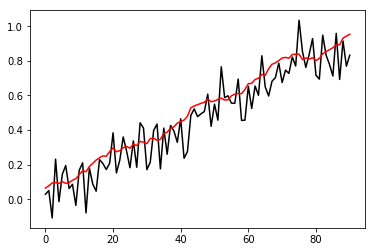

In [90]:
%matplotlib inline
f = plt.figure()
plt.plot(x[:-k+1], '-k');
plt.plot(x_avg, '-r')

In [97]:
%timeit shift1(x, k)

10000 loops, best of 3: 36 µs per loop


In [98]:
%%timeit y = shift1(x, k)
z = y.mean(axis=0)

100000 loops, best of 3: 14.8 µs per loop


In [99]:
%timeit shift2(x, k)

100000 loops, best of 3: 13.9 µs per loop


In [100]:
%%timeit y = shift2(x, k)
z = y.mean(axis=0)

The slowest run took 4.50 times longer than the fastest. This could mean that an intermediate result is being cached.
100000 loops, best of 3: 15.4 µs per loop


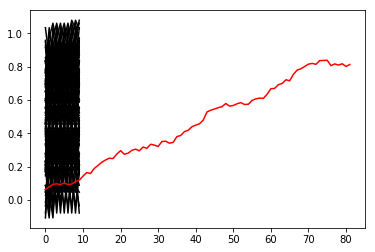

In [106]:
y

array([[ 0.02912065,  0.05067211, -0.10739724,  0.23186   , -0.01357973,
         0.14503045,  0.19504712,  0.06260704,  0.0864429 , -0.03488359,
         0.16767392,  0.21059692, -0.07812113,  0.18060184,  0.08838245,
         0.04680946,  0.22979751,  0.20639788,  0.17217983,  0.2086519 ,
         0.38399341,  0.15274384,  0.22718083,  0.36024491,  0.27869906,
         0.18242157,  0.33738855,  0.18518483,  0.44256993,  0.41156068,
         0.17145083,  0.21428924,  0.39722333,  0.43467019,  0.17578976,
         0.41142522,  0.26058105,  0.42655566,  0.39432622,  0.32935514,
         0.46545148,  0.23695166,  0.27619651,  0.48452484,  0.52250581,
         0.47745778,  0.49378717,  0.50753387,  0.60762513,  0.42160222,
         0.54949118,  0.45718628,  0.76559366,  0.58741169,  0.59790528,
         0.55555531,  0.55471182,  0.69437059,  0.45557998,  0.45730578,
         0.65268418,  0.52473007,  0.65454522,  0.60096862,  0.82922958,
         0.64906179,  0.59697159,  0.68180124,  0.7